In [1]:
import torch

In [2]:
from torchvision import datasets

In [3]:
download_dir = "./dataset"

# Скачиваем обучающую выборку.
train_data = datasets.CIFAR10(root=download_dir, download=True, train=True)

# Скачиваем валидационную выборку.
val_data = datasets.CIFAR10(root=download_dir, download=True, train=False)

100%|██████████| 170M/170M [00:05<00:00, 29.6MB/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


In [4]:
# Объекты данных из обучающей выборки (50 000 цветных картинок размера 32 x 32).
x_train = torch.tensor(train_data.data)
x_train.shape

torch.Size([50000, 32, 32, 3])

In [5]:
# Предсказываемые величины для обучающей выборки (50 000 чисел от 0 до 9).
y_train = torch.tensor(train_data.targets)

print(y_train.shape, y_train.min(), y_train.max(), sep="\n")

torch.Size([50000])
tensor(0)
tensor(9)


In [6]:
# Сопоставление численных значений
#  (индексов в списке classes) реальным классам.
classes = train_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
# Названия классов на русском языке.
classes_ru = [
    "самолёт",
    "машина",
    "птица",
    "кошка",
    "олень",
    "собака",
    "лягушка",
    "лошадь",
    "корабль",
    "грузовик",
]

In [8]:
# Аналогично записываем x и y для валидационной выборки (10 000 примеров).
x_val = torch.tensor(val_data.data)
y_val = torch.tensor(val_data.targets)

print(x_val.shape, y_val.shape, sep="\n")

torch.Size([10000, 32, 32, 3])
torch.Size([10000])


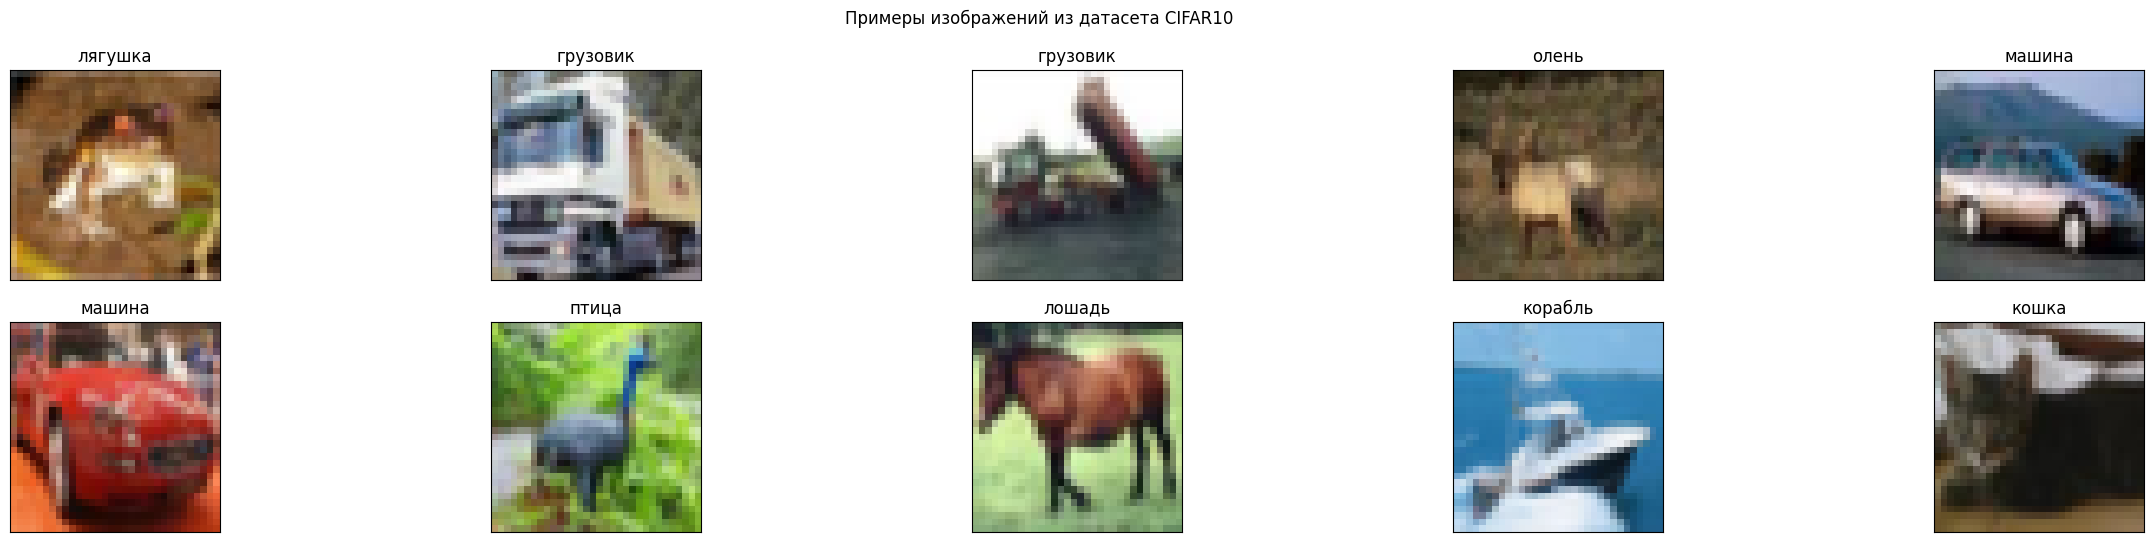

In [9]:
# Посмотрим на то, как выглядят картинки из датасета.

import matplotlib.pyplot as plt
%matplotlib inline

hh = 2
ww = 5

fig, ax = plt.subplots(hh, ww, figsize=(30, 3 * hh))
fig.suptitle("Примеры изображений из датасета CIFAR10")

for i, (x, y) in enumerate(zip(x_train, y_train)):
    if i >= hh * ww:
        break
    plt.subplot(hh, ww, i + 1)
    plt.imshow(x)
    plt.xticks([])
    plt.yticks([])
    plt.title(classes_ru[y])
plt.show()

In [10]:
# При обучении нейросетей нам будет удобнее работать
#  с пикселями, представленными в виде вещественных чисел.
x_train = torch.tensor(train_data.data) / 255.
x_val = torch.tensor(val_data.data) / 255.

print(x_train.min(), x_train.max(), x_train.dtype, sep="\n")

tensor(0.)
tensor(1.)
torch.float32


In [11]:
# Свёртка.
conv_layer = torch.nn.Conv2d(
    in_channels=3,         # Число каналов на входе.
    out_channels=10,       # Число каналов на выходе.
    kernel_size=3,         # Размер ядра.
    padding=1,             # Размер паддинга (1 элемент добавляется с каждой стороны).
    padding_mode="zeros",  # Указываем, что в паддинге проставляем нули вдоль границ входного тензора.
    stride=1,              # Stride - 1 (смотрим на каждую позицию).
    dilation=1,            # Dilation - 1 (ядро прикладывается к фрагменту изображения без пропусков).
)

# Применяется слой свёртки к группе картинок в формате bs x c x h x w.
x = torch.rand(2, 3, 32, 32)

print(f"Размер до свёртки: {x.shape}")

x = conv_layer(x)

print(f"Размер после свёртки: {x.shape}")

Размер до свёртки: torch.Size([2, 3, 32, 32])
Размер после свёртки: torch.Size([2, 10, 32, 32])


In [12]:
# Residual connection.
conv_layer_2 = torch.nn.Conv2d(
    in_channels=10,
    out_channels=10,
    kernel_size=3,
    padding=1,
)

x = torch.rand(2, 10, 32, 32)

print(f"Размер до свёртки: {x.shape}")

x2 = conv_layer_2(x)

print(f"Размер после свёртки: {x2.shape}")

h = x + x2

Размер до свёртки: torch.Size([2, 10, 32, 32])
Размер после свёртки: torch.Size([2, 10, 32, 32])


In [13]:
# Residual connection в ситуации, когда вход и выход
#  имеют разные количества каналов.
x = torch.rand(2, 3, 32, 32)

print(f"Размер до свёртки: {x.shape}")

x2 = conv_layer(x)

print(f"Размер после свёртки: {x2.shape}")

# Вариант 1: объединяем (конкатенируем) тензоры вдоль размерности каналов.
h = torch.cat([x, x2], dim=1)

print(f"Размер выхода при конкатенации: {h.shape}")


# Вариант 2: применяем свёртку с ядром 1x1, чтобы привести
#  исходный тензор к состоянию, когда число каналов
#  в нём совпадает с числом каналов в выходном тензоре.
conv_1_1 = torch.nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=1,  # Ищем шаблоны размера 1x1xc
)
h = conv_1_1(x) + x2

print(f"Размер выхода при сумме через 1x1 свёртку: {h.shape}")

Размер до свёртки: torch.Size([2, 3, 32, 32])
Размер после свёртки: torch.Size([2, 10, 32, 32])
Размер выхода при конкатенации: torch.Size([2, 13, 32, 32])
Размер выхода при сумме через 1x1 свёртку: torch.Size([2, 10, 32, 32])


In [14]:
class ResidualBlock(torch.nn.Module):
    # Инициализация блока.
    def __init__(
        self,
        input_c,                   # Число каналов на входе.
        output_c,                  # Число каналов на выходе.
        kernel_size,               # Размер ядра.
        activation=torch.nn.ReLU,  # Класс функции активации.
    ):
        super().__init__()

        # Функция активации для нелинейности.
        self.activation = activation()

        # TODO:
        # Паддинг подбираем такой, чтобы размеры h и w не менялись
        #  (считаем, что размер ядра всегда нечётный).
        padding_size = kernel_size // 2  # Для сохранения размера высоты и ширины

        # TODO:
        # Операция свёртки.
        # Создайте сверточный слой с помощью класса torch.nn.Conv2d
        # укажите количество каналов на входе и выходе, размер ядра,
        # размер паддинга и режим его выполнения (заполнение нулями)
        self.conv = torch.nn.Conv2d(
            in_channels=input_c,
            out_channels=output_c,
            kernel_size=kernel_size,
            padding=padding_size,
            padding_mode="zeros",
            stride=1,
        )

        # Если числа каналов у входа и выхода различаются,
        if input_c != output_c:
            # TODO:
            # то будем делать свёртку с ядром размера 1.
            self.correct_channels = torch.nn.Conv2d(
                in_channels=input_c,
                out_channels=output_c,
                kernel_size=1,
            )
        else:
            self.correct_channels = torch.nn.Identity()  # Слой, никак не меняющий вход.

    # Прямой проход.
    def forward(self, x):
        # TODO:
        # реализуйте прямой проход
        identity = self.correct_channels(x)  # Корректируем число каналов входного тензора
        x = self.conv(x)                     # Применяем свёртку
        x = self.activation(x)               # Применяем активацию
        x = x + identity                     # Добавляем residual connection
        return x

In [15]:
# TODO:
# Создайте экземпляр класса ResidualBlock() у которого 3 канала на входе, 10 каналов на выходе,
# размер ядра свертки равен 3 и
# в качестве функции активации используется ReLU
# Создаем экземпляр класса ResidualBlock
residual_block = ResidualBlock(
    input_c=3,                  # 3 канала на входе
    output_c=10,                # 10 каналов на выходе
    kernel_size=3,              # Размер ядра свертки 3x3
    activation=torch.nn.ReLU,   # Используем ReLU в качестве функции активации
)


In [16]:
import torch.nn as nn
# TODO:
# Создайте экземпляр класса ResidualBlock() у которого 10 каналов на входе, 10 каналов на выходе и
# размер ядра свертки равен 3 и
# в качестве функции активации используется "Гиперболический тангенс"
# Создаем экземпляр класса ResidualBlock
residual_block = ResidualBlock(
    input_c=10,        # Число каналов на входе.
    output_c=10,       # Число каналов на выходе.
    kernel_size=3,     # Размер ядра.
    activation=nn.Tanh # Функция активации.
)


In [17]:
from collections import OrderedDict

conv_layers = [
    (
        "residual_block_1",
        # Создаём первый residual block с 3 каналами на входе и 8 каналами на выходе
        ResidualBlock(
            input_c=3,                  # 3 канала на входе (например, RGB изображение)
            output_c=8,                 # 8 каналов на выходе
            kernel_size=3,              # Размер ядра свертки 3x3
            activation=torch.nn.ReLU,   # Используем ReLU в качестве функции активации
        ),
    ),
    (
        "residual_block_2",
        # Создаём второй residual block с 8 каналами на входе и 16 каналами на выходе
        ResidualBlock(
            input_c=8,                  # 8 каналов на входе
            output_c=16,                # 16 каналов на выходе
            kernel_size=3,              # Размер ядра свертки 3x3
            activation=torch.nn.ReLU,   # Используем ReLU в качестве функции активации
        ),
    ),
    (
        "pooling",
        torch.nn.MaxPool2d(kernel_size=2),  # Слой подвыборки (уменьшает размеры h и w в 2 раза)
    ),
    (
        "residual_block_3",
        # Создаём третий residual block с 16 каналами на входе и 32 каналами на выходе
        ResidualBlock(
            input_c=16,                 # 16 каналов на входе
            output_c=32,                # 32 канала на выходе
            kernel_size=3,              # Размер ядра свертки 3x3
            activation=torch.nn.ReLU,   # Используем ReLU в качестве функции активации
        ),
    ),
]

# Создаём последовательную модель из слоёв
conv_model = torch.nn.Sequential(OrderedDict(conv_layers))
conv_model

Sequential(
  (residual_block_1): ResidualBlock(
    (activation): ReLU()
    (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (correct_channels): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
  )
  (residual_block_2): ResidualBlock(
    (activation): ReLU()
    (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (correct_channels): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (residual_block_3): ResidualBlock(
    (activation): ReLU()
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (correct_channels): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [18]:
# С помощью функции max в torch можно сделать MaxPooling.
h = torch.rand(2, 3)

print(h, h.max(1), h.max(1).values.shape, h[0, :], h[1, :], sep="\n\n")

tensor([[0.4572, 0.5291, 0.3376],
        [0.8272, 0.0092, 0.1102]])

torch.return_types.max(
values=tensor([0.5291, 0.8272]),
indices=tensor([1, 0]))

torch.Size([2])

tensor([0.4572, 0.5291, 0.3376])

tensor([0.8272, 0.0092, 0.1102])


In [19]:
from collections import OrderedDict

lin_layers = [
    (
        "linear_1",
        # Создаём полносвязный слой с 32 входами и 16 выходами
        torch.nn.Linear(
            in_features=32,  # Количество входных признаков (32)
            out_features=16, # Количество выходных признаков (16)
        ),
    ),
    (
        "linear_activation_1",
        # Используем ReLU в качестве функции активации
        torch.nn.ReLU(),
    ),
    (
        "linear_2",
        # Создаём полносвязный слой с 16 входами и 10 выходами
        torch.nn.Linear(
            in_features=16,  # Количество входных признаков (16)
            out_features=10, # Количество выходных признаков (10)
        ),
    ),
    (
        "softmax",
        torch.nn.Softmax(dim=-1),  # Softmax для получения вероятностей классов
    ),
]

# Создаём последовательную модель из слоёв
lin_model = torch.nn.Sequential(OrderedDict(lin_layers))
lin_model

Sequential(
  (linear_1): Linear(in_features=32, out_features=16, bias=True)
  (linear_activation_1): ReLU()
  (linear_2): Linear(in_features=16, out_features=10, bias=True)
  (softmax): Softmax(dim=-1)
)

In [20]:
# Посмотрим на примере.
x = torch.rand(2, 3, 32, 32)

print(f"Изначальный размер: {x.shape}")

# Применяем свёрточные слои.
x = conv_model(x)

print(f"После свёрток: {x.shape}")

# Сделаем операцию GlobalMaxPooling.
x = x.max(-1).values.max(-1).values

print(f"После глобального пулинга: {x.shape}")

# Применяем классификатор.
x = lin_model(x)

print(f"После классификатора: {x.shape}\n")

print(x, x.sum(1), sep="\n\n")

Изначальный размер: torch.Size([2, 3, 32, 32])
После свёрток: torch.Size([2, 32, 16, 16])
После глобального пулинга: torch.Size([2, 32])
После классификатора: torch.Size([2, 10])

tensor([[0.1013, 0.0913, 0.1023, 0.0831, 0.0865, 0.0973, 0.1026, 0.1226, 0.1129,
         0.1001],
        [0.1014, 0.0917, 0.1030, 0.0828, 0.0866, 0.0968, 0.1017, 0.1235, 0.1140,
         0.0984]], grad_fn=<SoftmaxBackward0>)

tensor([1.0000, 1.0000], grad_fn=<SumBackward1>)


In [21]:
# Повторим задание свёрточной нейронной сети на основе residual block,
# но в более общем виде при помощи обёртки torch.nn.Module.
IMG_SIZE = 32

class ResidualModel(torch.nn.Module):
    def __init__(
        self,
        out_size,                    # Число классов.
        residual_sizes,              # Задаём список троек: количество residual-блоков,
                                     #  число каналов и размер ядра в каждом таком блоке.
        linear_sizes,                # Список размеров линейных слоёв в финальном классификаторе.
        activation = torch.nn.ReLU,  # Какую функцию активации использовать.
        flatten = True,              # Использовать Flatten или GlobalPooling.
    ):
        super().__init__()
        self.flatten = flatten

        # Собираем все свёрточные слои в один блок.
        conv_layers = []

        current_c = 3
        for group_index, (num_residual, out_channels, kernel_size) in enumerate(residual_sizes):
            for residual_index in range(num_residual):
                conv_layers.append((
                    # Добавляем несколько residual-блоков для каждой группы.
                    f"residual_{group_index}_{residual_index}",
                    ResidualBlock(
                        input_c = current_c if residual_index == 0 else out_channels,
                        output_c = out_channels,
                        kernel_size = kernel_size,
                        activation = activation,
                    ),
                ))
            current_c = out_channels
            if group_index < len(residual_sizes) - 1:
                conv_layers.append((
                    # В конце группы добавляем один pooling-слой,
                    # если это не последняя группа.
                    f"pooling_{group_index}",
                    torch.nn.AvgPool2d(2),
                ))

        self.conv_part = torch.nn.Sequential(OrderedDict(conv_layers))

        # Собираем все линейные слои во второй блок.
        out_c = residual_sizes[-1][1]
        final_size = IMG_SIZE // 2 ** (len(residual_sizes) - 1)
        clf_in_size = (out_c * final_size**2) if flatten else out_c

        linear_sizes = [clf_in_size, *linear_sizes, out_size]

        clf_layers = []

        for i, (from_size, to_size) in enumerate(zip(linear_sizes[:-1], linear_sizes[1:])):
            clf_layers.append((f"linear_{i}", torch.nn.Linear(from_size, to_size)))
            if i < len(linear_sizes) - 2:
                clf_layers.append((f"act_{i}", activation()))
            else:
                clf_layers.append(("log_softmax", torch.nn.LogSoftmax(-1)))

        self.clf_part = torch.nn.Sequential(OrderedDict(clf_layers))

    def forward(self, x):  # input (bs x h x w x c_in)
        x = x.permute((0, 3, 1, 2))  # (bs x c_in x h x w)

        x = self.conv_part(x)  # bs x c_out x h' x w'

        if self.flatten:
            # Операция Flatten.
            x = x.reshape(x.shape[0], -1)  # bs x (c_out * h' * w')
        else:
            # Операция GlobalMaxPooling.
            x = x.max(-1).values.max(-1).values  # bs x c_out


        x = self.clf_part(x)  # bs x 10

        return x




In [22]:
def print_num_params(model):
    # Считаем общее количество обучаемых весов в модели.
    sum_params_size = 0
    for name, param in model.named_parameters():
        param_size = param.numel()
        print("{:<46} ~ {:<14} ~ {}".format(name, str(list(param.shape)), param_size))
        sum_params_size += param_size
    print(f"Общее число параметров ~ {sum_params_size}")


In [23]:
model = ResidualModel(
    out_size=10,
    residual_sizes=[(2, 8, 3), (2, 16, 3), (2, 32, 3), (2, 32, 3)],
    linear_sizes=[32],
    activation=torch.nn.ReLU,
    flatten=True,
)

model

ResidualModel(
  (conv_part): Sequential(
    (residual_0_0): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    )
    (residual_0_1): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Identity()
    )
    (pooling_0): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (residual_1_0): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (residual_1_1): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Identity()
    )
    (pooling_1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (residual_2_0): Re

In [24]:
print_num_params(model)

conv_part.residual_0_0.conv.weight             ~ [8, 3, 3, 3]   ~ 216
conv_part.residual_0_0.conv.bias               ~ [8]            ~ 8
conv_part.residual_0_0.correct_channels.weight ~ [8, 3, 1, 1]   ~ 24
conv_part.residual_0_0.correct_channels.bias   ~ [8]            ~ 8
conv_part.residual_0_1.conv.weight             ~ [8, 8, 3, 3]   ~ 576
conv_part.residual_0_1.conv.bias               ~ [8]            ~ 8
conv_part.residual_1_0.conv.weight             ~ [16, 8, 3, 3]  ~ 1152
conv_part.residual_1_0.conv.bias               ~ [16]           ~ 16
conv_part.residual_1_0.correct_channels.weight ~ [16, 8, 1, 1]  ~ 128
conv_part.residual_1_0.correct_channels.bias   ~ [16]           ~ 16
conv_part.residual_1_1.conv.weight             ~ [16, 16, 3, 3] ~ 2304
conv_part.residual_1_1.conv.bias               ~ [16]           ~ 16
conv_part.residual_2_0.conv.weight             ~ [32, 16, 3, 3] ~ 4608
conv_part.residual_2_0.conv.bias               ~ [32]           ~ 32
conv_part.residual_2_0.corre

In [25]:
# Создаем модель с использованием глобального MaxPooling
model = ResidualModel(
    out_size=10,  # Число классов
    residual_sizes=[(2, 8, 3), (2, 16, 3), (2, 32, 3), (2, 32, 3)],  # Список residual-блоков
    linear_sizes=[32],  # Размеры линейных слоёв в классификаторе
    activation=torch.nn.ReLU,  # Функция активации
    flatten=False,  # Используем GlobalMaxPooling вместо Flatten
)

# Выводим структуру модели
print(model)

ResidualModel(
  (conv_part): Sequential(
    (residual_0_0): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    )
    (residual_0_1): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Identity()
    )
    (pooling_0): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (residual_1_0): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (residual_1_1): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Identity()
    )
    (pooling_1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (residual_2_0): Re

In [26]:
# TODO:
# выведите подробную информацию о коичечестве параметров этой неросети
print_num_params(model)

conv_part.residual_0_0.conv.weight             ~ [8, 3, 3, 3]   ~ 216
conv_part.residual_0_0.conv.bias               ~ [8]            ~ 8
conv_part.residual_0_0.correct_channels.weight ~ [8, 3, 1, 1]   ~ 24
conv_part.residual_0_0.correct_channels.bias   ~ [8]            ~ 8
conv_part.residual_0_1.conv.weight             ~ [8, 8, 3, 3]   ~ 576
conv_part.residual_0_1.conv.bias               ~ [8]            ~ 8
conv_part.residual_1_0.conv.weight             ~ [16, 8, 3, 3]  ~ 1152
conv_part.residual_1_0.conv.bias               ~ [16]           ~ 16
conv_part.residual_1_0.correct_channels.weight ~ [16, 8, 1, 1]  ~ 128
conv_part.residual_1_0.correct_channels.bias   ~ [16]           ~ 16
conv_part.residual_1_1.conv.weight             ~ [16, 16, 3, 3] ~ 2304
conv_part.residual_1_1.conv.bias               ~ [16]           ~ 16
conv_part.residual_2_0.conv.weight             ~ [32, 16, 3, 3] ~ 4608
conv_part.residual_2_0.conv.bias               ~ [32]           ~ 32
conv_part.residual_2_0.corre

In [27]:
import matplotlib.pyplot as plt

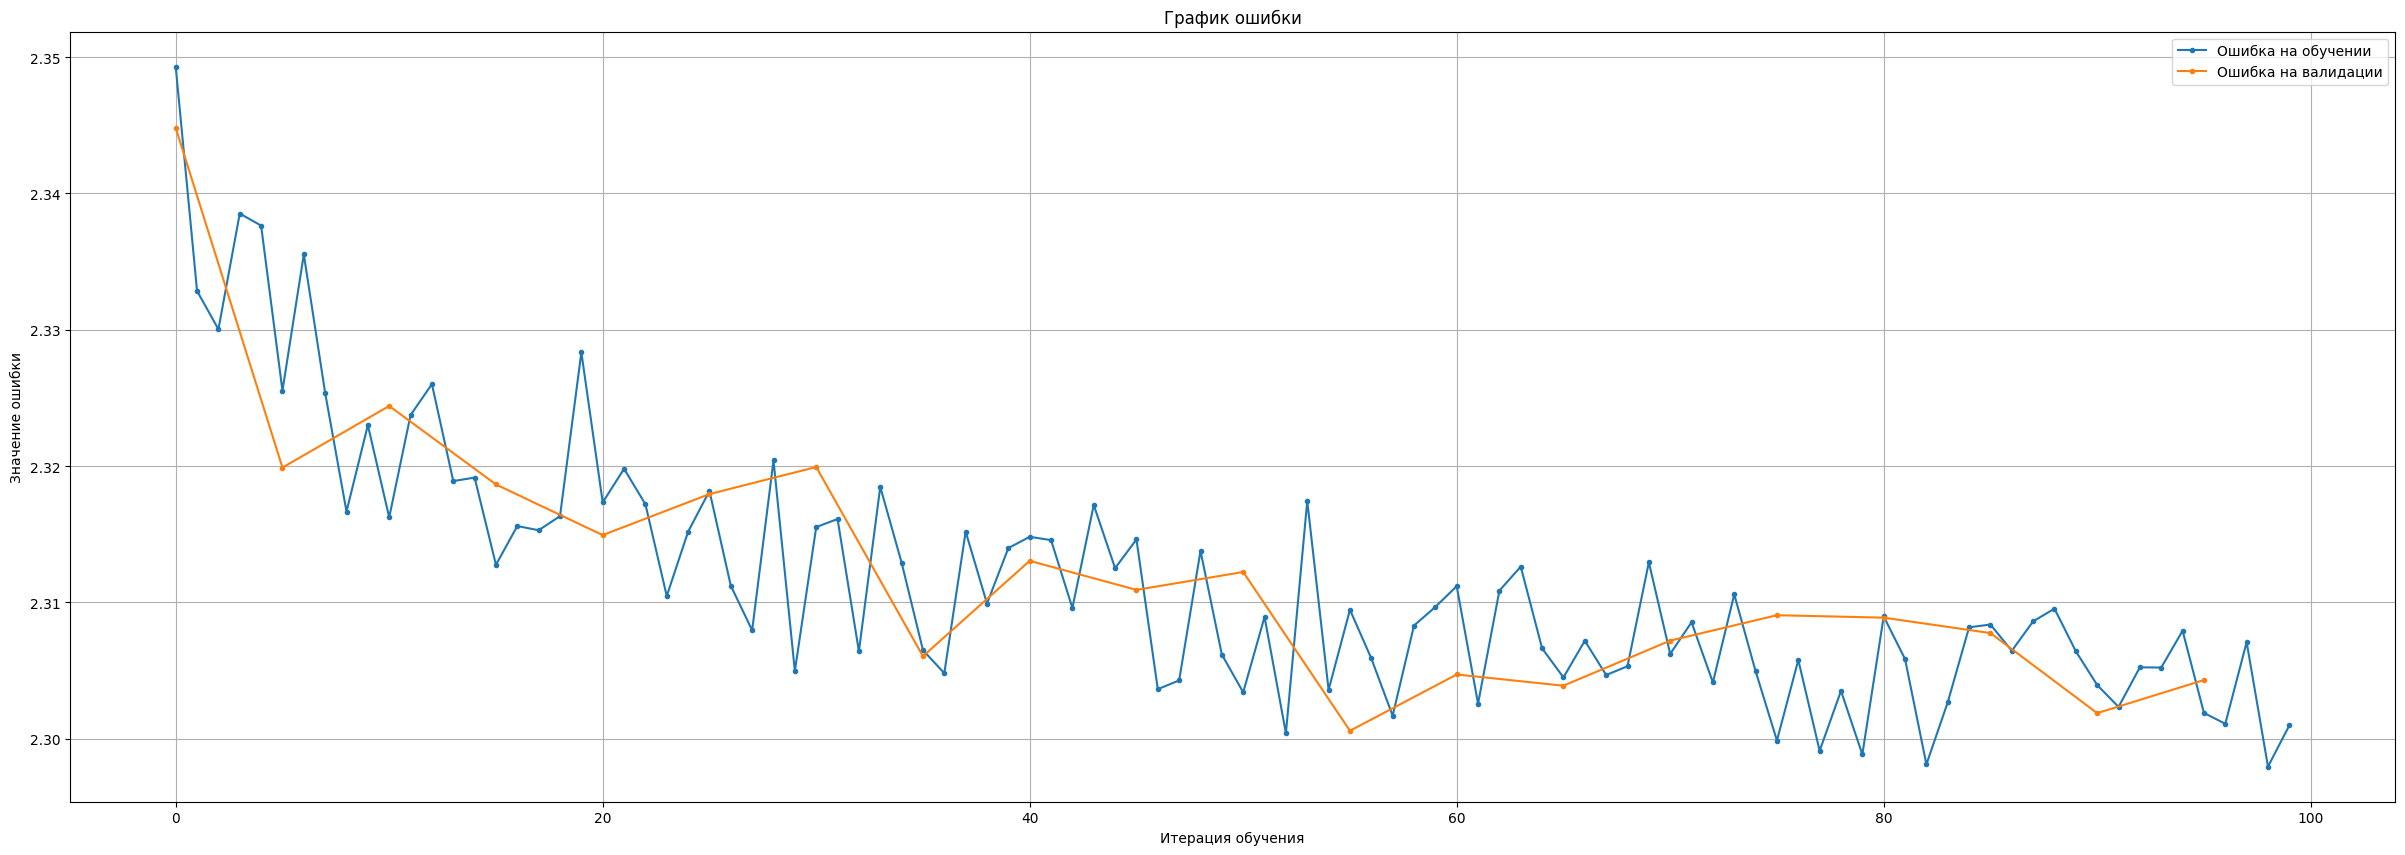

KeyboardInterrupt: 

In [29]:
# Реализуем цикл обучения модели.
# ВАЖНО, что обучение модели с параметрами, приведёнными ниже, работает очень долго.

from IPython.display import clear_output

# Для ускорения обучения используем видеокарту компьютера
#  или виртуальной машины, если есть такая возможность.
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 5000
batch_size = 1000
val_every = 5

model = ResidualModel(
    out_size=10,
    residual_sizes=[(2, 8, 3), (2, 16, 3), (2, 32, 3)],
    linear_sizes=[32],
    activation=torch.nn.ReLU,
    flatten=False,
).to(dtype=x_train.dtype, device=device)  # Важно, чтобы все тензоры были одного типа и на одном устройстве.

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,
)

# Шедулер (scheduler) отвечает за изменение величины шага градиентного спуска, который
#  в данном случае мы будем постепенно уменьшать с течением времени.
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

loss_fn = torch.nn.NLLLoss()

losses = {"train": [], "val": []}

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()

    # Будем на каждой итерации обучения брать не все 50 000 картинок,
    #  а лишь случайные batch_size из них.
    batch_pos = torch.randint(high=x_train.shape[0], size=[batch_size])

    pred = model(x_train[batch_pos].to(device))  # Также переносим тензоры на устойство.
    loss = loss_fn(pred, y_train[batch_pos].to(device))

    loss.backward()
    optimizer.step()

    losses["train"].append(loss.item())

    # Каждые val_every итераций считаем значение loss на валидационной выборке.
    if epoch % val_every == 0:
        with torch.no_grad():
            val_batch_pos = torch.randint(high=x_val.shape[0], size=[batch_size])
            val_pred = model(x_val[val_batch_pos].to(device))
            val_loss = loss_fn(val_pred, y_val[val_batch_pos].to(device))
            losses["val"].append(val_loss.item())

    # Каждые 1000 итераций уменьшаем шаг градиентного спуска.
    if epoch % 1000 == 0:
        scheduler.step()

    # Каждые 100 итераций рисуем графики loss.
    if epoch % 100 == 0:
        clear_output(True)
        fig, ax = plt.subplots(figsize=(30, 10))
        plt.title("График ошибки")
        plt.plot(losses["train"], ".-", label="Ошибка на обучении")
        plt.plot(torch.arange(0, epoch, val_every), losses["val"], ".-", label="Ошибка на валидации")
        plt.xlabel("Итерация обучения")
        plt.ylabel("Значение ошибки")
        plt.legend()
        plt.grid()
        plt.show()

In [ ]:
# Посмотрим на предсказания нашей модели на примерах из валидационной выборки.

classes_ru = [
    "самолёт",
    "машина",
    "птица",
    "кошка",
    "олень",
    "собака",
    "лягушка",
    "лошадь",
    "корабль",
    "грузовик",
]

def show_results(model, h=2, w=5):
    with torch.no_grad():
        batch_probs = model(x_val[:h*w].to(device)).exp()

        fig, ax = plt.subplots(h, w, figsize=(30, 9 * h))
        for i in range(h * w):
            plt.subplot(h, w, i+1)
            plt.imshow(x_val[i])
            title = f'Реальный класс: {classes_ru[y_val[i]]}\n\nПредсказания:'
            y_pred = torch.argmax(batch_probs[i])
            for j, prob in enumerate(batch_probs[i]):
                title += '\n{}{}{: <10} : {}'.format(
                    "" if j != y_pred else "> ",
                    "" if j != y_val[i] else "+ ",
                    classes_ru[j],
                    round(prob.item(), 4),
                )

            plt.title(title)
            plt.xticks([])
            plt.yticks([])
        plt.show()

show_results(model)

#### Задание.
Примените технологию residual connection для нейросети из задания № 2.

1) Опишите архитектуру нейросети

2) Создайте экземпляр класса ResidualModel

3) Проведите обучение нейронной сети. Сделайте отображение величины ошибки для тренировочной и валидационной выборки нак графике в процесе вычислений (аналогично примеру выше).

4) Отобразите результат классификации с указанием класса-результата и верного ответа для 10 случайных картинок тестовой выборки (аналогично примеру выше).
5) Сравните точность полученной модели с той, что была реализована в задании № 2.
   

In [37]:
from torchvision import datasets, transforms
import torch

# Параметры для подготовки данных
download_dir = "./kmnist_dataset"

# Преобразования для изображений
transform = transforms.Compose([
    transforms.ToTensor(),  # Преобразование изображения в тензор
])

# Загрузка обучающей выборки
kmnist_train = datasets.KMNIST(root=download_dir, train=True, download=True, transform=transform)

# Загрузка валидационной выборки
kmnist_val = datasets.KMNIST(root=download_dir, train=False, download=True, transform=transform)

# Получение данных и меток
x_train = kmnist_train.data.float().unsqueeze(1) / 255.0  # Добавляем канал (1 для grayscale)
y_train = kmnist_train.targets

x_val = kmnist_val.data.float().unsqueeze(1) / 255.0  # Добавляем канал (1 для grayscale)
y_val = kmnist_val.targets

# Количество классов
num_classes = len(kmnist_train.classes)

# Проверка размеров данных
print(f"Размер обучающей выборки: {x_train.shape}, {y_train.shape}")
print(f"Размер валидационной выборки: {x_val.shape}, {y_val.shape}")

Размер обучающей выборки: torch.Size([60000, 1, 28, 28]), torch.Size([60000])
Размер валидационной выборки: torch.Size([10000, 1, 28, 28]), torch.Size([10000])


In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

# Определение ResidualBlock
class ResidualBlock(nn.Module):
    def __init__(self, input_c, output_c, kernel_size, activation=nn.ReLU):
        super().__init__()
        padding_size = kernel_size // 2

        self.block = nn.Sequential(
            nn.Conv2d(input_c, output_c, kernel_size, padding=padding_size),
            nn.BatchNorm2d(output_c),
            activation(),
            nn.Conv2d(output_c, output_c, kernel_size, padding=padding_size),
            nn.BatchNorm2d(output_c)
        )

        self.shortcut = nn.Sequential()
        if input_c != output_c:
            self.shortcut = nn.Sequential(
                nn.Conv2d(input_c, output_c, kernel_size=1),
                nn.BatchNorm2d(output_c)
            )

        self.activation = activation()

    def forward(self, x):
        identity = self.shortcut(x)
        x = self.block(x)
        x += identity
        x = self.activation(x)
        return x

# Определение ResidualModel
class ResidualModel(nn.Module):
    def __init__(self, num_classes, residual_sizes, linear_sizes, input_channels=1, activation=nn.ReLU, flatten=True):
        super().__init__()
        self.flatten = flatten

        # Сверточные слои
        conv_layers = []
        current_c = input_channels
        for group_index, (num_residual, out_channels, kernel_size) in enumerate(residual_sizes):
            for residual_index in range(num_residual):
                conv_layers.append((f"residual_{group_index}_{residual_index}",
                                    ResidualBlock(current_c, out_channels, kernel_size, activation)))
                current_c = out_channels
            if group_index < len(residual_sizes) - 1:
                conv_layers.append((f"pooling_{group_index}", nn.AvgPool2d(2)))

        self.conv_part = nn.Sequential(OrderedDict(conv_layers))

        # Линейные слои
        out_c = residual_sizes[-1][1]
        final_size = max(1, 28 // (2 ** (len(residual_sizes) - 1)))
        clf_in_size = out_c * final_size * final_size if flatten else out_c

        linear_layers = []
        sizes = [clf_in_size] + linear_sizes + [num_classes]
        for i in range(len(sizes) - 1):
            linear_layers.append((f"linear_{i}", nn.Linear(sizes[i], sizes[i+1])))
            if i < len(sizes) - 2:
                linear_layers.append((f"act_{i}", activation()))

        self.clf_part = nn.Sequential(OrderedDict(linear_layers))

    def forward(self, x):
        x = self.conv_part(x)
        if self.flatten:
            x = torch.flatten(x, 1)
        x = self.clf_part(x)
        return x

# Создание модели
model = ResidualModel(
    num_classes=num_classes,
    residual_sizes=[(2, 16, 3), (2, 32, 3), (2, 64, 3)],
    linear_sizes=[128],
    input_channels=1,
    activation=nn.ReLU,
    flatten=True,
)

Epoch 1/100, Train Loss: 0.1665, Val Loss: 0.2995
Epoch 2/100, Train Loss: 0.0527, Val Loss: 0.2090
Epoch 3/100, Train Loss: 0.0343, Val Loss: 0.1912
Epoch 4/100, Train Loss: 0.0237, Val Loss: 0.1443
Epoch 5/100, Train Loss: 0.0178, Val Loss: 0.1452
Epoch 6/100, Train Loss: 0.0150, Val Loss: 0.1432
Epoch 7/100, Train Loss: 0.0153, Val Loss: 0.1509
Epoch 8/100, Train Loss: 0.0149, Val Loss: 0.1358
Epoch 9/100, Train Loss: 0.0102, Val Loss: 0.1490
Epoch 10/100, Train Loss: 0.0109, Val Loss: 0.2410
Epoch 11/100, Train Loss: 0.0089, Val Loss: 0.1849
Epoch 12/100, Train Loss: 0.0070, Val Loss: 0.1877
Epoch 13/100, Train Loss: 0.0076, Val Loss: 0.1715
Epoch 14/100, Train Loss: 0.0069, Val Loss: 0.1831
Epoch 15/100, Train Loss: 0.0048, Val Loss: 0.1830
Epoch 16/100, Train Loss: 0.0099, Val Loss: 0.1991
Epoch 17/100, Train Loss: 0.0050, Val Loss: 0.1566
Epoch 18/100, Train Loss: 0.0031, Val Loss: 0.1696
Epoch 19/100, Train Loss: 0.0083, Val Loss: 0.1618
Epoch 20/100, Train Loss: 0.0085, Val Lo

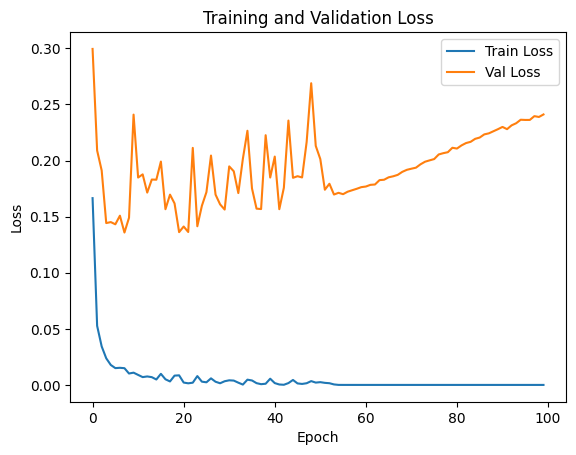

In [59]:
# Параметры обучения
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #

batch_size = 128
num_epochs = 100  # Уменьшено количество эпох для демонстрации
learning_rate = 0.001

# Оптимизатор и функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# Подготовка данных для обучения
train_data = torch.utils.data.TensorDataset(x_train, y_train)
val_data = torch.utils.data.TensorDataset(x_val, y_val)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Обучение
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Валидация
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Визуализация ошибок (после завершения обучения)
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')  # Добавляем подписи осей
plt.ylabel('Loss')
plt.title('Training and Validation Loss') # Добавляем заголовок
plt.legend()
plt.show()

In [60]:
# Оценка на валидационной выборке
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
print(f"Точность на валидационной выборке: {accuracy * 100:.2f}%")

Точность на валидационной выборке: 98.12%


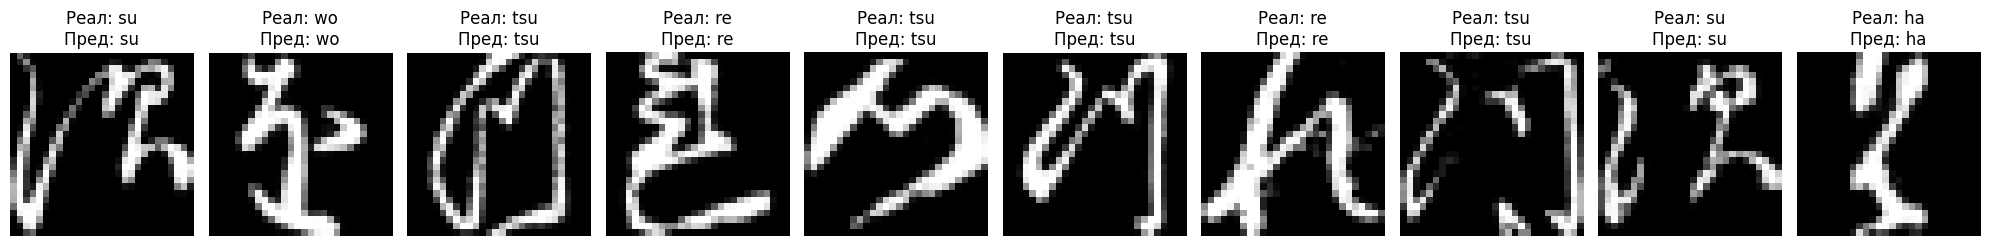

In [61]:
def show_results(model, data_loader, classes, num_samples=10):
    model.eval()
    with torch.no_grad():
        x_batch, y_batch = next(iter(data_loader))
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        _, predicted = torch.max(outputs.data, 1)

        plt.figure(figsize=(20, 3))
        for j in range(min(num_samples, x_batch.size(0))):
            plt.subplot(1, num_samples, j + 1)
            img = x_batch[j].cpu().squeeze()
            plt.imshow(img, cmap='gray')
            plt.title(f"Реал: {classes[y_batch[j].cpu()]}\nПред: {classes[predicted[j].cpu()]}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

# Показать результаты
show_results(model, val_loader, kmnist_train.classes)